# Set and load data

In [1]:
!pip install tensorflow opencv-python matplotlib

In [41]:
import os
import tensorflow as tf

# Avoid OOM errors by setting GPU Memory Consumption Growth
# Do not use up all memory

In [42]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [43]:
data_dir = "../Data"
os.listdir(data_dir)
# os.listdir(os.path.join(data_dir, "train1"))

['Testing Set', 'Training Set']

In [44]:
import cv2
import matplotlib.pyplot as plt
import imghdr
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [45]:
image_exts = ["jpeg","jpg","bmp", "png"]

In [46]:
img = cv2.imread(os.path.join(data_dir, "Training Set", "IDRiD_001.jpg"))

In [47]:
img.shape

(2848, 4288, 3)

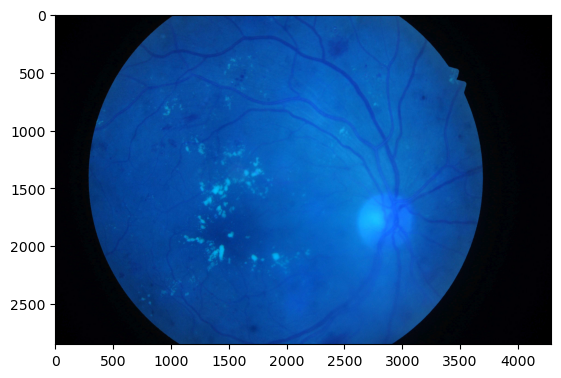

In [48]:
plt.imshow(img)

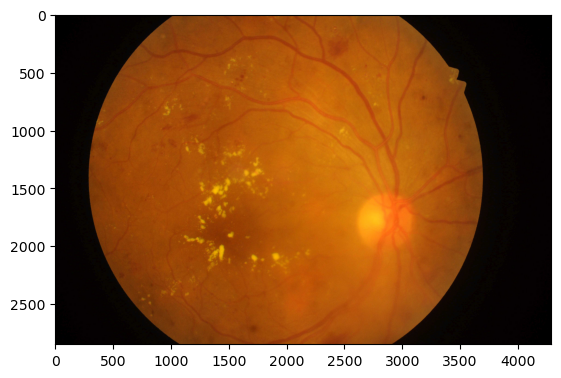

In [49]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [50]:
# from struct import unpack
#
# marker_mapping = {
#     0xffd8: "Start of Image",
#     0xffe0: "Application Default Header",
#     0xffdb: "Quantization Table",
#     0xffc0: "Start of Frame",
#     0xffc4: "Define Huffman Table",
#     0xffda: "Start of Scan",
#     0xffd9: "End of Image"
# }
#
# class JPEG:
#     def __init__(self, image_file):
#         with open(image_file, 'rb') as f:
#             self.img_data = f.read()
#
#     def decode(self):
#         data = self.img_data
#         while(True):
#             marker, = unpack(">H", data[0:2])
#             # print(marker_mapping.get(marker))
#             if marker == 0xffd8:
#                 data = data[2:]
#             elif marker == 0xffd9:
#                 return
#             elif marker == 0xffda:
#                 data = data[-2:]
#             else:
#                 lenchunk, = unpack(">H", data[2:4])
#                 data = data[2+lenchunk:]
#             if len(data)==0:
#                 break

In [51]:
# bads = []
#
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         image = JPEG(image_path)
#         try:
#             image.decode()
#         except:
#             bads.append(img)

In [52]:
# for name in bads:
#     os.remove(os.path.join(data_dir, name))

In [53]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image.path))

# Build data pipeline

In [54]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 516 files belonging to 2 classes.


In [55]:
data_iterator = data.as_numpy_iterator()

In [56]:
data_iterator

# Get another batch from the iterator

In [57]:
batch = data_iterator.next()

# images, classes

In [58]:
len(batch)

2

# Images represented as  numpy arrays
# batch size 32, 32 images of shape 256 by 256 by 3 channels

In [59]:
batch[0].shape

(32, 256, 256, 3)

# Class 0 = test
# Class 1 = train

In [60]:
batch[1]

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1])

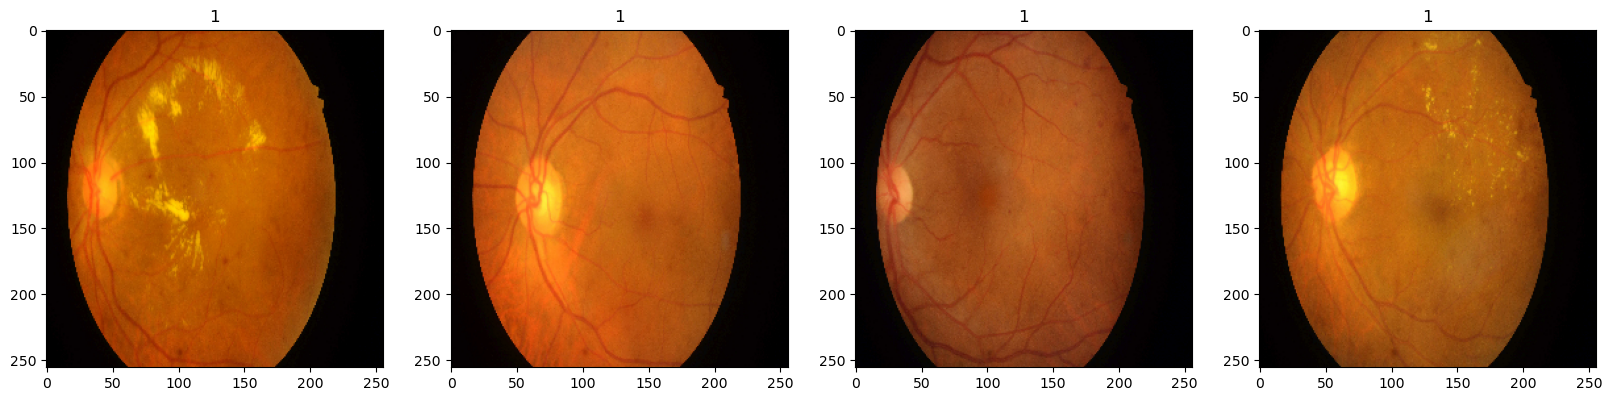

In [61]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocess Data
# RGB values 0 to 255
# We want the values to be as small as possible, help to optimize faster
# Divide shape by 255, so values 0 to 1

# Scale Data
# Perform transformation in pipeline

In [62]:
scaled_data = data.map(lambda x,y: (x/255, y))

In [63]:
scaled_iterator = scaled_data.as_numpy_iterator()

In [64]:
scaled_iterator.next()[0].max()

1.0

In [65]:
len(scaled_data)

17

# Split Data
# training data is used to train deep learning model
# validation data is used to evaluate model while training
# testing data is to do evaluation

In [66]:
train_size = int(len(scaled_data) * .7)
val_size = int(len(scaled_data) * .2)
test_size = int(len(scaled_data) * .1) + 1

In [67]:
train_size + val_size + test_size

16

In [68]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size + val_size).take(test_size)

In [69]:
len(test)

2

# Deep Model
# Build Deep Learning Model

In [70]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [71]:
# model = Sequential([Conv2D()])

In [72]:
model = Sequential()

In [73]:
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [74]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

# Train

In [76]:
logdir = "logs"

In [77]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [78]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
11/11 [==============================] - 7s 500ms/step - loss: 0.6127 - accuracy: 0.7585 - val_loss: 0.4244 - val_accuracy: 0.8438
Epoch 2/20
11/11 [==============================] - 6s 416ms/step - loss: 0.4980 - accuracy: 0.8068 - val_loss: 0.4484 - val_accuracy: 0.8333
Epoch 3/20
11/11 [==============================] - 6s 437ms/step - loss: 0.4503 - accuracy: 0.8182 - val_loss: 0.4999 - val_accuracy: 0.7917
Epoch 4/20
11/11 [==============================] - 6s 433ms/step - loss: 0.4710 - accuracy: 0.8011 - val_loss: 0.4490 - val_accuracy: 0.8333
Epoch 5/20
11/11 [==============================] - 6s 404ms/step - loss: 0.5012 - accuracy: 0.7756 - val_loss: 0.3759 - val_accuracy: 0.8333
Epoch 6/20
11/11 [==============================] - 6s 426ms/step - loss: 0.4655 - accuracy: 0.7699 - val_loss: 0.4720 - val_accuracy: 0.8125
Epoch 7/20
11/11 [==============================] - 6s 400ms/step - loss: 0.4332 - accuracy: 0.7955 - val_loss: 0.4298 - val_accuracy: 0.8229
Epoch 

# Plot Performance

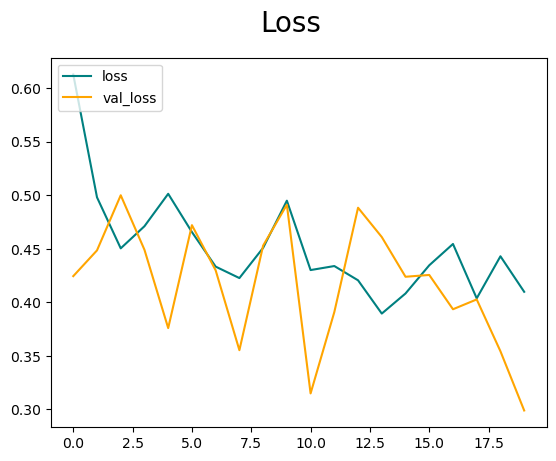

In [79]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

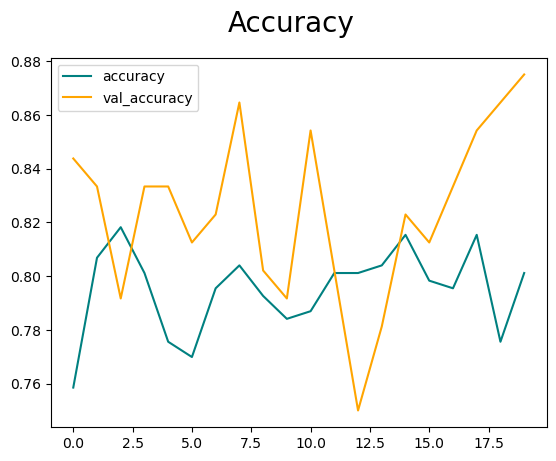

In [80]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="teal", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate Performance

In [81]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [82]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [83]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 89ms/step


In [84]:
print(f"Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}")

Precision:0.9166666865348816, Recall:1.0, Accuracy:0.921875


# Test

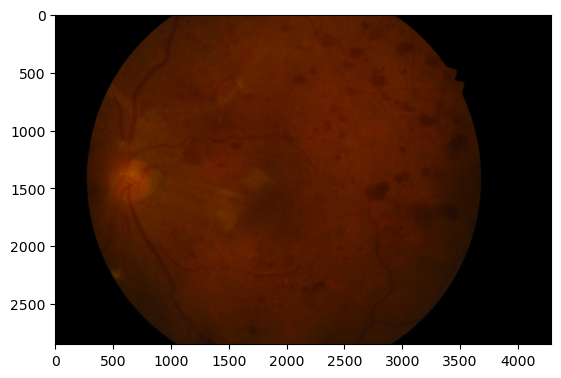

In [92]:
img = cv2.imread("../Data/Testing Set/IDRiD_001.jpg")
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

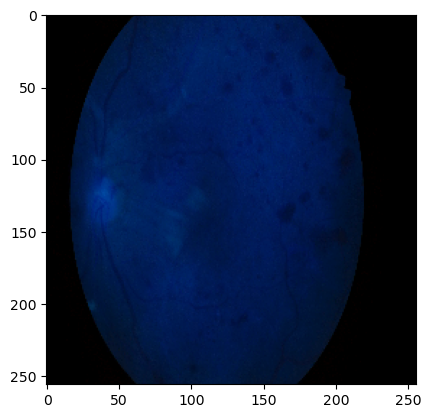

In [94]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [95]:
import numpy as np

In [96]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 217ms/step


In [97]:
if yhat == 0:
    print(f"Predicted class is healthy")
elif yhat == 1:
    print(f"Predicted class is at stage 1")
elif yhat == 2:
    print(f"Predicted class is at stage 2")
elif yhat == 3:
    print(f"Predicted class is at stage 3")
elif yhat == 4:
    print(f"Predicted class is at stage 4")

# Save the Model

In [98]:
from tensorflow.keras.models import load_model

In [101]:
model.save(os.path.join("models", "Staging.h5"))

In [102]:
new_model = load_model(os.path.join("models", "Staging.h5"))

In [103]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 93ms/step


array([[0.9933086]], dtype=float32)

In [104]:
if yhat == 0:
    print(f"Predicted class is healthy")
elif yhat == 1:
    print(f"Predicted class is at stage 1")
elif yhat == 2:
    print(f"Predicted class is at stage 2")
elif yhat == 3:
    print(f"Predicted class is at stage 3")
elif yhat == 4:
    print(f"Predicted class is at stage 4")